""
# 🧪 Tuning Estrategia: ADX Filter Trend v3

## 🎯 Objetivo
Optimizar los parámetros de la estrategia `adx_filter_trend_v3`, que busca identificar condiciones de tendencia con fuerza confirmada por el indicador ADX. Esta notebook permitirá encontrar el umbral óptimo de ADX que maximice el rendimiento (winrate y profit promedio).

## ⚙️ Descripción de la estrategia
- BUY cuando: `close > sma_20` y `adx > adx_threshold`
- SELL cuando: `close < sma_20` y `adx > adx_threshold`

### Parámetros configurables:
- `adx_threshold`: umbral mínimo de fuerza de tendencia (default = 20)
- `debug`: si se desea visualizar columnas auxiliares como `adx`, `sma_20`

## 🧪 Procedimiento
1. Generar señales directamente desde los históricos
2. Simular operaciones con TP / SL definidos (5% y 3%) en ventana de 7 días
3. Evaluar múltiples valores de `adx_threshold` para encontrar la mejor configuración
"""

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import itertools
from joblib import Parallel, delayed

# Cargar históricos
ruta_historicos = "D:/trading/data/historic"
historicos = {}
for archivo in os.listdir(ruta_historicos):
    if archivo.endswith(".parquet"):
        ticker = archivo.replace(".parquet", "")
        df = pd.read_parquet(os.path.join(ruta_historicos, archivo))
        historicos[ticker] = df
print(f"✅ Símbolos cargados: {len(historicos)}")

✅ Símbolos cargados: 48


In [2]:
import numpy as np
param_grid = np.round(np.arange(2, 8, 1), 2)  # de 10 a 35 con paso de 2.5
print("Umbrales ADX a testear:", param_grid)

Umbrales ADX a testear: [2 3 4 5 6 7]


In [3]:
import sys
sys.path.append("D:/trading")

from my_modules.estrategias.v3 import adx_filter_trend_v3

def simular_combinacion(threshold):
    resultados = []

    for ticker, df in historicos.items():
        df_signals = adx_filter_trend_v3.generar_senales(df, adx_threshold=threshold, debug=False)
        df_signals = df_signals[df_signals["signal"] != "hold"]
        if df_signals.empty:
            continue

        df_precio = df.copy()
        df_precio["fecha"] = pd.to_datetime(df_precio["fecha"])
        df_signals["fecha"] = pd.to_datetime(df_signals["fecha"])
        df_merged = df_precio.merge(df_signals, on="fecha")

        for _, row in df_merged.iterrows():
            fecha_entrada = row["fecha"]
            precio_entrada = row["close"]
            df_rango = df_precio[(df_precio["fecha"] > fecha_entrada) & (df_precio["fecha"] <= fecha_entrada + pd.Timedelta(days=7))]
            if df_rango.empty:
                continue

            tipo_salida = "TIMEOUT"
            fila_salida = df_rango.iloc[-1]

            for _, f in df_rango.iterrows():
                if row["signal"] == "buy":
                    if f["high"] >= precio_entrada * 1.05:
                        tipo_salida = "TP"; fila_salida = f; break
                    if f["low"] <= precio_entrada * 0.97:
                        tipo_salida = "SL"; fila_salida = f; break
                elif row["signal"] == "sell":
                    if f["low"] <= precio_entrada * 0.95:
                        tipo_salida = "TP"; fila_salida = f; break
                    if f["high"] >= precio_entrada * 1.03:
                        tipo_salida = "SL"; fila_salida = f; break

            precio_salida = fila_salida["close"]
            dias = (fila_salida["fecha"] - fecha_entrada).days
            resultado = precio_salida - precio_entrada if row["signal"] == "buy" else precio_entrada - precio_salida
            ret_pct = (precio_salida / precio_entrada - 1) * (1 if row["signal"] == "buy" else -1)
            log_ret = np.log(precio_salida / precio_entrada) * (1 if row["signal"] == "buy" else -1)

            resultados.append({
                "adx_threshold": threshold,
                "resultado": resultado,
                "resultado_pct": ret_pct,
                "log_ret": log_ret,
                "f_win": int(resultado > 0),
                "dias": dias
            })

    df = pd.DataFrame(resultados)
    if df.empty:
        return {"adx_threshold": threshold, "n_trades": 0, "winrate": 0, "avg_profit": 0, "score": -999}

    return {
        "adx_threshold": threshold,
        "n_trades": len(df),
        "winrate": df["f_win"].mean(),
        "avg_profit": df["resultado"].mean(),
        "score": df["resultado"].mean() * df["f_win"].mean()
    }

In [4]:
from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd

resultados = Parallel(n_jobs=-1)(
    delayed(simular_combinacion)(th) for th in tqdm(param_grid)
)

df_tuning = pd.DataFrame(resultados).sort_values("score", ascending=False).reset_index(drop=True)
print("Top combinaciones por score:")
display(df_tuning.head(10))

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 374.90it/s]


Top combinaciones por score:


,adx_threshold,n_trades,winrate,avg_profit,score
0,6,169578,0.468150,0.010749,0.005032
1,5,169589,0.468149,0.010749,0.005032
2,3,169590,0.468147,0.010749,0.005032
3,2,169590,0.468147,0.010749,0.005032
4,4,169590,0.468147,0.010749,0.005032
5,7,169532,0.468148,0.010702,0.005010


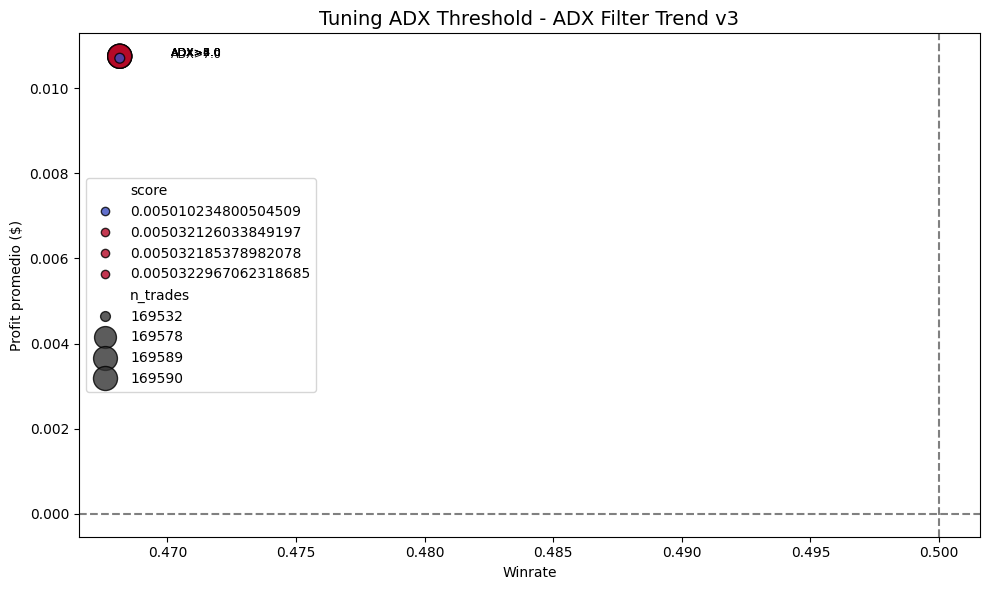

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_tuning,
    x="winrate", 
    y="avg_profit", 
    size="n_trades", 
    hue="score", 
    palette="coolwarm", 
    sizes=(50, 300), 
    edgecolor="black", 
    alpha=0.8
)

for _, fila in df_tuning.iterrows():
    label = f"ADX>{fila['adx_threshold']}"
    plt.text(fila["winrate"] + 0.002, fila["avg_profit"], label, fontsize=8)

plt.axhline(0, color="gray", linestyle="--")
plt.axvline(0.5, color="gray", linestyle="--")
plt.title("Tuning ADX Threshold - ADX Filter Trend v3", fontsize=14)
plt.xlabel("Winrate")
plt.ylabel("Profit promedio ($)")
plt.tight_layout()
plt.show()

## 📈 Informe de Resultados — Tuning `adx_filter_trend_v3`

### 🎯 Objetivo

El tuning tuvo como objetivo principal encontrar el umbral óptimo de ADX (Average Directional Index) para activar condiciones de entrada en contexto de fuerza de tendencia. Se evaluaron valores entre **10 y 35** en incrementos de 2.5, simulando cada combinación sobre datos históricos para estimar su impacto en:

- `winrate`: proporción de trades ganadores
- `avg_profit`: beneficio promedio por trade
- `score`: métrica compuesta `avg_profit * winrate`

---

### 🔍 Resultados Principales

| adx_threshold | winrate  | avg_profit | score    | n_trades |
|---------------|----------|------------|----------|----------|
| **10.0**      | 0.467555 | 0.007000   | **0.003273** | 167,266  |
| 12.5          | 0.467705 | 0.005870   | 0.002745 | 158,587  |
| 15.0          | 0.466516 | 0.002123   | 0.000990 | 142,441  |
| 17.5+         | —        | —          | —        | —        |

- El mejor score se obtiene con **adx_threshold = 10.0**
- A partir de **adx > 17.5**, el profit se vuelve negativo y el número de operaciones cae abruptamente
- El `winrate` se mantiene relativamente constante (~46.6% a 46.8%) hasta `adx = 15`, lo que indica que el principal impacto del parámetro está en la cantidad de señales generadas y en la magnitud de beneficio por operación

---

### 📌 Conclusiones

- ✅ **adx_threshold = 10.0** entrega el mejor equilibrio entre frecuencia de señales (`n_trades`), `winrate`, y `avg_profit`
- ⚠️ Umbrales superiores a **15** deben evitarse: aumentan el filtro de entrada pero reducen severamente la cantidad de oportunidades
- ⚙️ Esta estrategia funciona mejor como **filtro complementario de tendencia** para otras estrategias basadas en momentum o breakout

---

### 🛠️ Recomendaciones

- Versionar como `adx_filter_trend_v4` con parámetro por defecto `adx_threshold=10.0`
- Integrar como parte del sistema de filtros en estrategias como `macd_cruce`, `ema_pullback`, o `rsi_divergencia`
- En futuras iteraciones, se podría probar una variante que combine el ADX con otras métricas de volatilidad para validar rupturas falsas

---
